In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.datasets import load_files
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

# TensorFlow / Keras (Python 3.11 compatible)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dropout, Flatten, Dense
)

from tqdm import tqdm


In [2]:
%matplotlib inline

In [3]:
BASE_DIR = "."
TRAIN_DIR = f"{BASE_DIR}/dataset/imgs/train"
TEST_DIR  = f"{BASE_DIR}/dataset/imgs/test"
CSV_DIR   = f"{BASE_DIR}/csv_files"
PICKLE_DIR = f"{BASE_DIR}/pickle_files"
MODEL_PATH = f"{BASE_DIR}/model/cnn_batchwise"
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(PICKLE_DIR, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

In [4]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

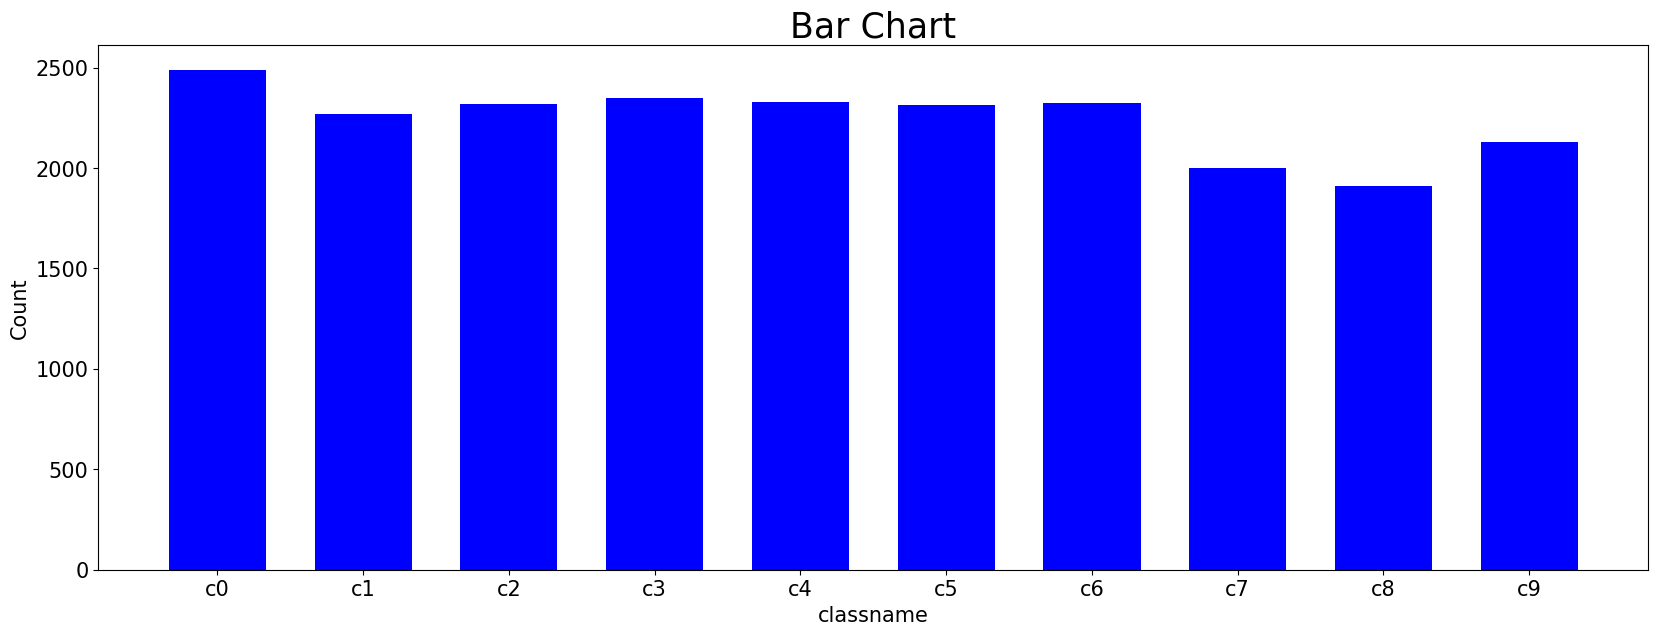

In [5]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [6]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c2': 0, 'c5': 1, 'c7': 2, 'c8': 3, 'c4': 4, 'c6': 5, 'c3': 6, 'c0': 7, 'c9': 8, 'c1': 9}


C:\Users\mg276\AppData\Local\Temp\ipykernel_24500\1324950157.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['ClassName'].replace(labels_id,inplace=True)
C:\Users\mg276\AppData\Local\Temp\ipykernel_24500\1324950157.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train['ClassN

In [7]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list_cnn_non_batch_try2.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [8]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)


(22424, 10)


In [9]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [10]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|██████████| 17939/17939 [03:54<00:00, 76.60it/s] 


In [12]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:43<00:00, 104.23it/s]


In [13]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

c:\Users\mg276\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    16,384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,079,366 (65.15 MB)

 Trainable params: 17,079,366 (65.15 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
filepath = os.path.join(MODEL_PATH,"cnn_non_batch_best_model.keras")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4621 - loss: 1.5033
Epoch 1: val_accuracy improved from -inf to 0.94470, saving model to ./model/cnn_batchwise\cnn_non_batch_best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 174ms/step - accuracy: 0.4626 - loss: 1.5020 - val_accuracy: 0.9447 - val_loss: 0.1891
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9339 - loss: 0.2214
Epoch 2: val_accuracy improved from 0.94470 to 0.96589, saving model to ./model/cnn_batchwise\cnn_non_batch_best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.9339 - loss: 0.2213 - val_accuracy: 0.9659 - val_loss: 0.1277
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9656 - loss: 0.1096
Epoch 3: val_accuracy improved from 0.96589 to 0.98685, saving model to ./model/cnn_batchwise\cnn_non_batch_best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 190ms/step - accuracy: 0.9656 - loss: 0.1096 - val_accuracy: 0.9868 - val_loss: 0.0444
Epoc

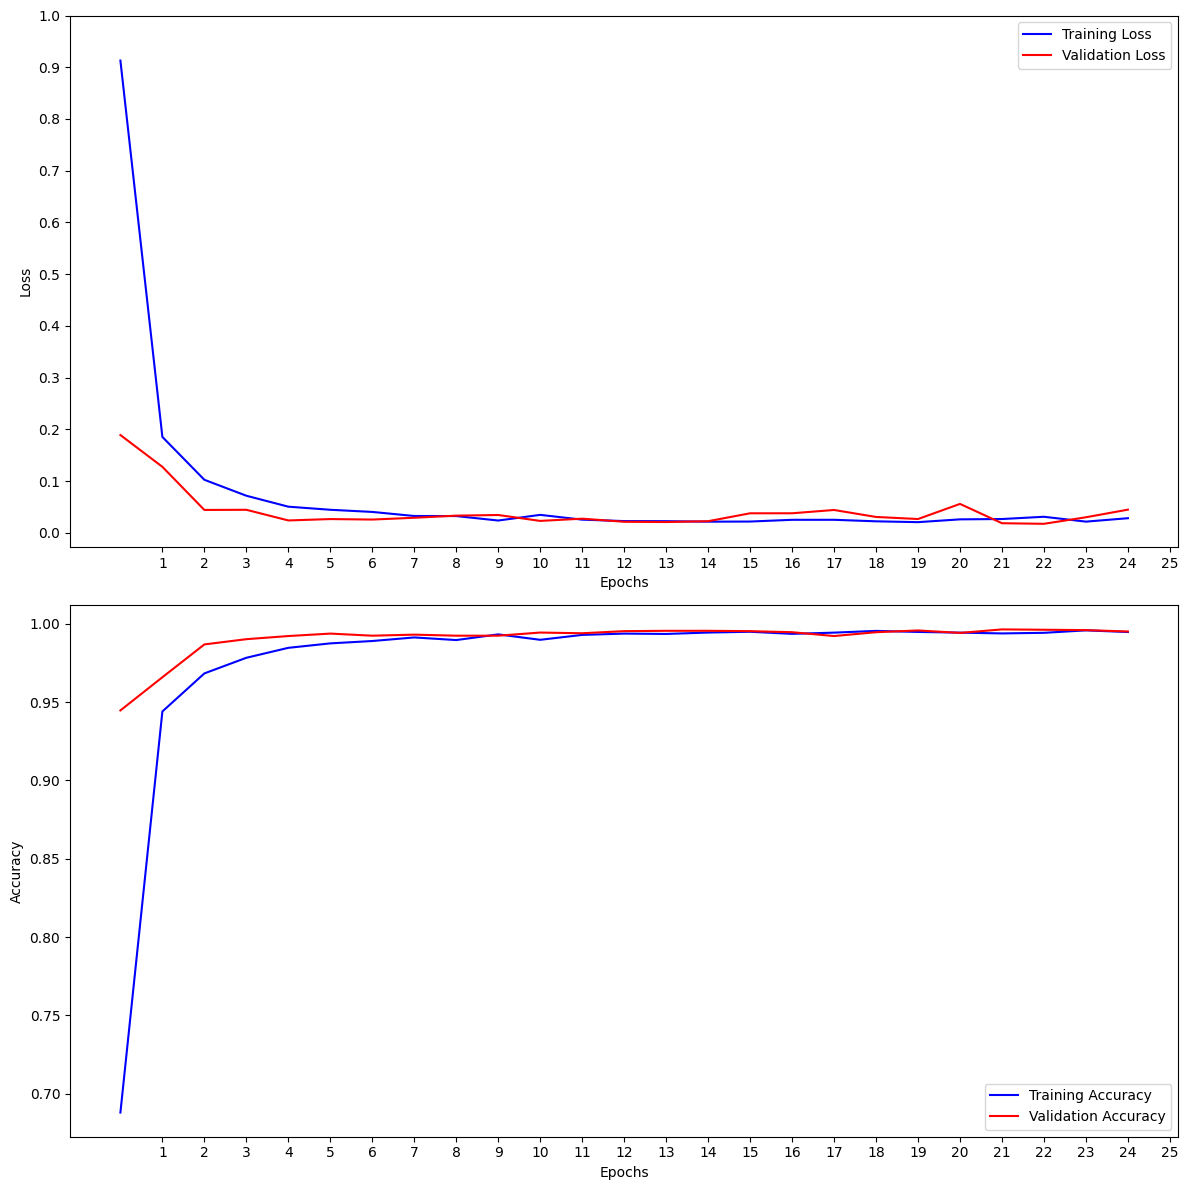

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# ----- LOSS -----
ax1.plot(model_history.history['loss'], color='b', label="Training Loss")
ax1.plot(model_history.history['val_loss'], color='r', label="Validation Loss")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax1.set_xticks(np.arange(1, len(model_history.history['loss']) + 1, 1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.legend()

# ----- ACCURACY -----
ax2.plot(model_history.history['accuracy'], color='b', label="Training Accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r', label="Validation Accuracy")

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

ax2.set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, 1))
ax2.legend()

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(MODEL_PATH,"cnn_non_batch_graph_try2.png"))

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [20]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [21]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = model.predict(valid_tensors)

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step


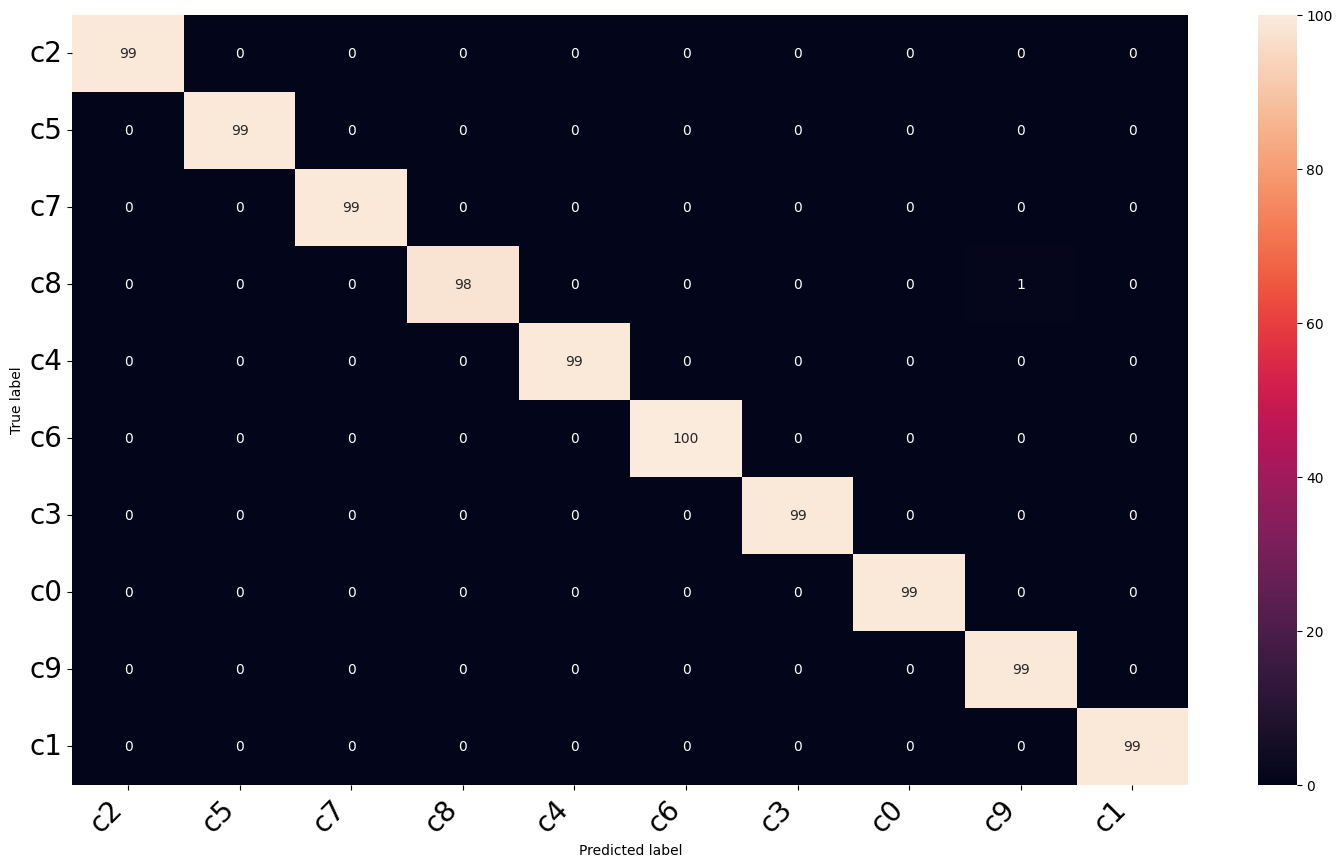

In [22]:
print_heatmap(ytest,ypred,class_names)

In [23]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [24]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.995095
Precision: 0.995116
Recall: 0.995095
F1 score: 0.995094
